In [1]:

import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp
from genpen.utils import Paper
from scipy import stats
import geopandas
from shapely.errors import TopologicalError
import functools
import vpype
from skimage import io
from pathlib import Path

from sklearn.preprocessing import minmax_scale
from skimage import feature
from skimage import exposure
from torch import Tensor
from torch import nn
from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import disk
from numpy.random import default_rng


from PIL import Image
import attr

import cv2
from rasterio import features
import rasterio

import pydiffvg as dg
import torch
import skimage
import numpy as np
from torchvision.transforms import functional as TF
from IPython import display
from copy import deepcopy
import fn
import torch.nn.functional as F


from genpen.diffvg import diffvg as gdg
import clip


%load_ext autoreload
%autoreload 2

In [2]:
# Use GPU if available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
clip_model, preprocess = clip.load("ViT-B/32", device=device)
dg.set_device(device)

In [17]:
from genpen.diffvg.diffvg import (
    ParamHead, ShapeGroupMaker, 
    ShapeMaker, LazySigmoid, 
    CanvasNet, LazyRelu,
    CanvasNIMANet, CanvasCLIPNet, init_weights
    )

def rescale(x, min_val, max_val):
    min_val = torch.tensor(min_val)
    max_val = torch.tensor(max_val)
    return x * (max_val - min_val) + min_val

class Rescaler(nn.Module):
    def __init__(self, min_val, max_val):
        super().__init__()
        self.min_val = min_val
        self.max_val = max_val
        
    def forward(self, x):
        return x * (self.max_val - self.min_val) + self.min_val

class Reshape(nn.Module):
    
    def __init__(self, dims):
        super().__init__()
        self.dims = dims
        
    def forward(self, x):
        return x.view(self.dims)
    
class SigmoidParameter(nn.Module):
    
    def __init__(self, n_shapes, n_params):
        super().__init__()
        self.n_shapes = n_shapes
        self.n_params = n_params
        self.net = nn.Sequential(
            LazySigmoid(n_params*n_shapes),
            Reshape((n_shapes, n_params)),
        )
        
    def forward(self, x):
        return self.net(x)
    
class Squeezer(nn.Module):
    
    def forward(self, x):
        return x.squeeze()
    
def train(canvas_net, optim, loss_weights=None):
    
    shapes, shape_groups, tensors, img = canvas_net.forward()
    optim.zero_grad()
    losses = {}
    if loss_weights is None:
        loss_weights = {
            'big_rad_loss': 1,
            'overlap_loss': 1,
            'distance_loss': 1,
            'out_of_bounds_loss': 1,
            
        }
    overlap_buffer = 0
    shapes_tensors = tensors['shapes_tensors']
    # big rad 
    losses['big_rad_loss'] = shapes_tensors['radius'].exp().sum()

    # prevent overlap
    dists = torch.cdist(shapes_tensors['center'], shapes_tensors['center'])
    upper_dists = torch.triu(dists)
    nonzero_inds = torch.nonzero(upper_dists, as_tuple=True)
    dists[nonzero_inds]
    summed_rads = torch.atleast_2d(shapes_tensors['radius']).T + torch.atleast_2d(shapes_tensors['radius'])
    edge_to_edge_dists = dists[nonzero_inds] - summed_rads[nonzero_inds] - overlap_buffer
    losses['overlap_loss'] = F.relu(-edge_to_edge_dists).pow(3).sum()
    losses['distance_loss'] = edge_to_edge_dists.pow(2).sum()
    scaled_losses = {key: loss*loss_weights[key] for key, loss in losses.items()}
    loss = sum(scaled_losses.values())

    loss.backward()
    optim.step()
    
    scaled_losses['loss'] = loss
    return losses, scaled_losses, shapes, shape_groups, tensors

def train_nima(canvas_nima_net, optim, model_ft, canvas):
    
    optim.zero_grad()
    
    shapes, shape_groups, tensors, img = canvas_nima_net.forward()
    loss = canvas_nima_net.nima_loss(img)

    loss.backward()
    optim.step()
    
    return loss, shapes, shape_groups, tensors, img

def train_clip(canvas_clip_net, optim):
    
    optim.zero_grad()
    
    shapes, shape_groups, tensors, img = canvas_clip_net.forward()
    img.retain_grad()
    losses = canvas_clip_net.get_clip_losses(img)
    loss = torch.sum(*losses)

    loss.backward()
    optim.step()
    
    
    return loss, losses, shapes, shape_groups, tensors, img

def train_img(canvas_net, optim, target_img):
    
    optim.zero_grad()
    
    shapes, shape_groups, tensors, img = canvas_net.forward(torch.tensor([0.5], device=canvas_net.device))
    
    loss = ((target_img - img) ** 2).mean()

    loss.backward(retain_graph=True)
    optim.step()
    
    
    return loss, shapes, shape_groups, tensors, img

In [4]:
# from torchvision import datasets, models, transforms

# # Number of classes in the dataset
# num_classes = 10

# # Weight Path
# weight_path = '/home/naka/code/side/ML-Aesthetics-NIMA/weights/dense121_all.pt'

# model_ft = models.densenet121(pretrained=True)
# num_ftrs = model_ft.classifier.in_features
# model_ft.classifier = nn.Sequential(
#     nn.Linear(num_ftrs,num_classes),
#     nn.Softmax(1)
# )   

# # Send the model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_ft = model_ft.to(device)
# for param in model_ft.parameters():
#     param.requires_grad = False

In [190]:
n_shapes = 100
shape_param_head = ParamHead(nets={
    'center': SigmoidParameter(n_shapes, 2),
    'radius': nn.Sequential(SigmoidParameter(n_shapes, 1), Squeezer()),
    'stroke_width': nn.Sequential(SigmoidParameter(n_shapes, 1), Squeezer()),
})

param_transforms = {
    'center': Rescaler(24., 200.),
    'radius': Rescaler(4., 5.),
    'stroke_width': Rescaler( 0.3, 0.31),
}


shape_maker = ShapeMaker(
    shape_class=dg.Circle, 
    n_shapes=n_shapes,
    param_transforms=param_transforms,
    base_id=0,
    # init_params={
    #     'center': torch.rand(n_shapes, 2)/3,
    #     'radius': torch.rand(n_shapes, 1)/3,
    #     'stroke_width': torch.rand(n_shapes, 1)/3,
    # }
    )

shape_head = nn.Sequential(shape_param_head, shape_maker)

shape_groups_param_head = ParamHead(nets={
    'stroke_color': nn.Sequential(SigmoidParameter(1, 4), Squeezer()),  
    'fill_color': nn.Sequential(SigmoidParameter(1, 4), Squeezer()),  
})
shape_groups_maker = ShapeGroupMaker(
    shape_ids=shape_maker.ids,
    param_transforms={
        'stroke_color': lambda x: torch.tensor([1., 1., 1., 1.]),
        'fill_color': lambda x: None
        }
    )
shape_groups_head = nn.Sequential(shape_groups_param_head, shape_groups_maker)

canvas = gdg.Canvas(width=224, height=224)
canvas_net = CanvasNet(
    backbone=nn.Sequential(
        nn.Linear(1, 128),
        nn.ReLU(),
        LazyRelu(128),
        LazyRelu(128),
        LazyRelu(128),
    ),
    shapes_head=shape_head,
    shape_groups_head=shape_groups_head,
    canvas=canvas,
).to(device)
canvas_clip_net = CanvasCLIPNet(canvas_net, perceptor=clip_model).to(device)

/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [29]:
c = shapes[0]

In [13]:
c.radius

tensor([8.5927], grad_fn=<SelectBackward>)

In [30]:
c.stroke_width

tensor(0.4418, grad_fn=<SelectBackward>)

In [ ]:
params = shape_param_head.forward(torch.tensor([1., ]))
shapes, params = shape_maker.forward(params)

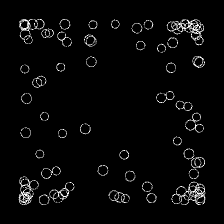

In [214]:
shapes, shape_groups, tensors, img = canvas_clip_net.forward()
canvas_clip_net.canvas_net.apply(init_weights);
shapes, shape_groups, tensors, img = canvas_clip_net.forward()

canvas.render(shapes, shape_groups, as_pil=True)

In [22]:
shapes, shape_groups, tensors, img = canvas_net.forward()

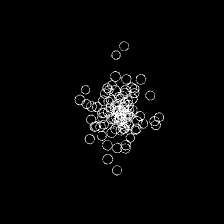

In [212]:
optim = torch.optim.Adam(canvas_net.parameters(), lr=1e-3)
losses, scaled_losses, shapes, shape_groups, tensors = train(
        loss_weights = {
            'big_rad_loss': 1e-4,
            'overlap_loss': 1,
            'distance_loss': 1e1,
            'out_of_bounds_loss': 1e0, 
            },
        canvas_net=canvas_net,
        optim=optim,
    )
canvas.render(shapes, shape_groups, as_pil=True)

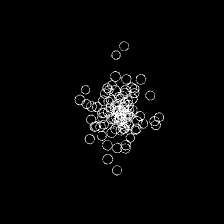

In [213]:
target_img = canvas.render(shapes, shape_groups).detach()
gdg.to_pil(target_img)

In [215]:
optim = torch.optim.Adam(canvas_net.parameters(), lr=3e-4)

tensor(0.0378, device='cuda:0', grad_fn=<MeanBackward0>)


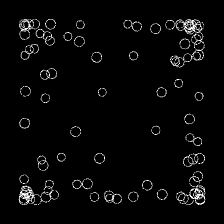

In [221]:


loss, shapes, shape_groups, tensors, img = train_img(canvas_net, optim, target_img)
print(loss)
gdg.to_pil(img)

In [224]:
ii % 100

99

  0%|          | 3/10000 [00:00<06:29, 25.67it/s]

tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 104/10000 [00:04<07:16, 22.68it/s]

tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 200/10000 [00:08<06:28, 25.24it/s]

tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 304/10000 [00:13<07:04, 22.85it/s]

tensor(0.0244, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 403/10000 [00:17<07:10, 22.31it/s]

tensor(0.0244, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 505/10000 [00:22<06:21, 24.86it/s]

tensor(0.0243, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 604/10000 [00:26<06:14, 25.07it/s]

tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 706/10000 [00:31<06:37, 23.37it/s]

tensor(0.0241, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 805/10000 [00:35<06:47, 22.57it/s]

tensor(0.0242, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 904/10000 [00:40<07:16, 20.85it/s]

tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 1003/10000 [00:44<06:28, 23.13it/s]

tensor(0.0243, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 1105/10000 [00:48<06:11, 23.97it/s]

tensor(0.0239, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 1204/10000 [00:53<05:41, 25.72it/s]

tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 1303/10000 [00:57<07:15, 19.99it/s]

tensor(0.0242, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 1405/10000 [01:02<07:13, 19.85it/s]

tensor(0.0239, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 1504/10000 [01:06<06:31, 21.68it/s]

tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 1603/10000 [01:10<05:25, 25.83it/s]

tensor(0.0241, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 1705/10000 [01:15<05:17, 26.09it/s]

tensor(0.0242, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 1804/10000 [01:19<06:07, 22.29it/s]

tensor(0.0241, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 1906/10000 [01:24<05:39, 23.86it/s]

tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 2005/10000 [01:28<05:43, 23.26it/s]

tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 2104/10000 [01:33<06:33, 20.06it/s]

tensor(0.0239, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 2204/10000 [01:37<05:44, 22.60it/s]

tensor(0.0238, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 2303/10000 [01:41<05:13, 24.55it/s]

tensor(0.0233, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 2405/10000 [01:46<05:03, 25.02it/s]

tensor(0.0234, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 2506/10000 [01:51<05:07, 24.35it/s]

tensor(0.0233, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 2605/10000 [01:55<05:22, 22.90it/s]

tensor(0.0235, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 2704/10000 [02:00<06:05, 19.94it/s]

tensor(0.0233, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 2803/10000 [02:04<04:55, 24.38it/s]

tensor(0.0237, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 2905/10000 [02:08<04:36, 25.63it/s]

tensor(0.0231, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 3004/10000 [02:13<04:51, 24.03it/s]

tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 3106/10000 [02:17<05:09, 22.30it/s]

tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 3202/10000 [02:22<04:50, 23.41it/s]

tensor(0.0227, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 3305/10000 [02:26<05:02, 22.10it/s]

tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 3404/10000 [02:31<04:19, 25.37it/s]

tensor(0.0230, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 3506/10000 [02:35<04:32, 23.87it/s]

tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 3605/10000 [02:39<04:05, 26.00it/s]

tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 3704/10000 [02:44<05:22, 19.54it/s]

tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 3806/10000 [02:48<04:07, 25.06it/s]

tensor(0.0227, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 3902/10000 [02:53<03:54, 25.99it/s]

tensor(0.0227, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 4004/10000 [02:57<04:16, 23.36it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 4106/10000 [03:02<03:47, 25.86it/s]

tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 4205/10000 [03:06<04:33, 21.19it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 4304/10000 [03:11<04:01, 23.55it/s]

tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 4400/10000 [03:15<03:37, 25.70it/s]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 4504/10000 [03:20<04:08, 22.14it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 4606/10000 [03:24<03:34, 25.20it/s]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 4702/10000 [03:29<04:27, 19.83it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 4801/10000 [03:33<03:35, 24.16it/s]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 4906/10000 [03:38<03:21, 25.28it/s]

tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 5005/10000 [03:42<04:08, 20.09it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 5104/10000 [03:46<03:34, 22.84it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 5206/10000 [03:51<03:08, 25.41it/s]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 5302/10000 [03:55<02:58, 26.29it/s]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 5404/10000 [04:00<03:11, 23.97it/s]

tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 5506/10000 [04:04<02:57, 25.26it/s]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 5605/10000 [04:09<03:04, 23.85it/s]

tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 5704/10000 [04:13<02:49, 25.33it/s]

tensor(0.0227, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 5806/10000 [04:17<02:41, 26.01it/s]

tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 5905/10000 [04:22<02:56, 23.15it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 6004/10000 [04:26<03:25, 19.43it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 6103/10000 [04:31<02:45, 23.50it/s]

tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 6205/10000 [04:35<02:33, 24.76it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 6304/10000 [04:39<02:21, 26.11it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 6406/10000 [04:44<02:21, 25.43it/s]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 6505/10000 [04:48<02:20, 24.88it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 6604/10000 [04:53<03:11, 17.76it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 6706/10000 [04:57<02:38, 20.81it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 6805/10000 [05:01<01:57, 27.23it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 6904/10000 [05:06<02:04, 24.95it/s]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 7005/10000 [05:10<02:00, 24.90it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 7103/10000 [05:15<01:57, 24.63it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 7205/10000 [05:19<01:47, 26.02it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 7304/10000 [05:24<02:45, 16.33it/s]

tensor(0.0221, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 7403/10000 [05:28<02:03, 21.03it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 7505/10000 [05:33<01:36, 25.76it/s]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 7603/10000 [05:37<01:43, 23.11it/s]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 7703/10000 [05:41<01:41, 22.54it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 7802/10000 [05:46<01:23, 26.40it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 7904/10000 [05:50<01:36, 21.80it/s]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 8003/10000 [05:55<01:17, 25.72it/s]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 8105/10000 [05:59<01:23, 22.63it/s]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 8204/10000 [06:03<01:11, 25.03it/s]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 8306/10000 [06:08<01:11, 23.86it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 8405/10000 [06:12<01:02, 25.39it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 8506/10000 [06:17<00:57, 25.92it/s]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 8600/10000 [06:21<00:53, 26.00it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 8705/10000 [06:26<01:05, 19.92it/s]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 8805/10000 [06:30<00:52, 22.59it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 8904/10000 [06:35<00:44, 24.56it/s]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 9006/10000 [06:39<00:38, 25.78it/s]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 9105/10000 [06:44<00:39, 22.38it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 9204/10000 [06:48<00:32, 24.15it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 9306/10000 [06:53<00:31, 22.36it/s]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 9407/10000 [06:57<00:20, 28.44it/s]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 9506/10000 [07:01<00:19, 25.84it/s]

tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 9602/10000 [07:05<00:15, 25.76it/s]

tensor(0.0219, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 9704/10000 [07:10<00:12, 23.29it/s]

tensor(0.0220, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 9800/10000 [07:14<00:08, 23.71it/s]

tensor(0.0220, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 9906/10000 [07:19<00:03, 24.42it/s]

tensor(0.0220, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 10000/10000 [07:23<00:00, 22.53it/s]

tensor(0.0220, device='cuda:0', grad_fn=<MeanBackward0>)


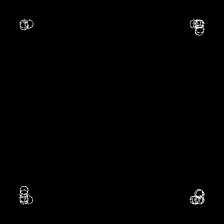

In [225]:
for ii in tqdm(range(10000)):
    loss, shapes, shape_groups, tensors, img = train_img(canvas_net, optim, target_img)
    if ii % 100 == 0:
        print(loss)
print(loss)
gdg.to_pil(img)

In [13]:
canvas_clip_net.set_text_prompts(['a smile made of circles'])

In [14]:
shapes, shape_groups, tensors, img = canvas_clip_net.forward()

In [ ]:
from torch import autograd
with autograd.detect_anomaly():
    loss, shapes, shape_groups, tensors, img = train_clip(canvas_clip_net, optim, )

In [ ]:
optim = torch.optim.Adam(canvas_clip_net.parameters(), lr=1e-2)
loss, shapes, shape_groups, tensors, img = train_clip(canvas_clip_net, optim, )
print(loss)
img

In [181]:
pydiffvg.get_device()

device(type='cuda', index=0)

In [5]:
import pydiffvg

canvas_width, canvas_height = 256, 256
circle = pydiffvg.Circle(radius = torch.tensor(40.0),
                         center = torch.tensor([128.0, 128.0]),
                         stroke_width = torch.tensor(5.0))
shapes = [circle]
circle_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([0]),
    fill_color = torch.tensor([0.3, 0.6, 0.3, 1.0]),
    stroke_color = torch.tensor([0.6, 0.3, 0.6, 0.8]))
shape_groups = [circle_group]
scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)

render = pydiffvg.RenderFunction.apply
img = render(256, # width
             256, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None,
             *scene_args)

# The output image is in linear RGB space. Do Gamma correction before saving the image.
target = img.clone()


In [22]:

# Move the circle to produce initial guess
# normalize radius & center for easier learning rate
radius_n = torch.tensor(20.0 / 256.0, requires_grad=False, device='cuda')
center_n = torch.tensor([108.0 / 256.0, 138.0 / 256.0], requires_grad=True, device='cuda')
fill_color_n = torch.tensor([0.3, 0.2, 0.8, 1.0], requires_grad=True, device='cuda')
stroke_color_n = torch.tensor([0.4, 0.7, 0.5, 0.5], requires_grad=True, device='cuda')
stroke_width_n = torch.tensor(10.0 / 100.0, requires_grad=True, device='cuda')

new_circle = pydiffvg.Circle(
    radius = radius_n * 256,
    center = center_n * 256,
    stroke_width=stroke_width_n * 100,
    )
shapes = [new_circle]

new_circle_group = pydiffvg.ShapeGroup(
    shape_ids = torch.tensor([0], device='cuda'),
    fill_color=fill_color_n,
    stroke_color=stroke_color_n,
    )
shape_groups = [new_circle_group]

scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
img = render(256, # width
             256, # height
             2,   # num_samples_x
             2,   # num_samples_y
             1,   # seed
             None,
             *scene_args)

In [41]:
net = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 2),
    nn.Sigmoid(),
).apply(init_weights).cuda()

In [42]:
dummy_input = torch.tensor([1.,]).cuda()

In [43]:
radius_n

tensor(0.0781, device='cuda:0')

In [190]:
optimizer = torch.optim.Adam(list(net.parameters()), lr=1e-2)

tensor([0.0781], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [44]:
optimizer = torch.optim.Adam(
    list(net.parameters()) + [ radius_n, fill_color_n, stroke_color_n, stroke_width_n], lr=1e-2)

In [35]:
list(net.parameters())[1].grad

In [39]:
img.grad.shape

torch.Size([256, 256, 4])

In [40]:
target.shape

torch.Size([256, 256, 4])

In [45]:
for t in tqdm(range(3)):
    optimizer.zero_grad()
    # Forward pass: render the image.
    
    new_circle = pydiffvg.Circle(
        radius = radius_n * 256,
        center = net.forward(dummy_input) * 256,
        stroke_width=stroke_width_n * 100,
        )
    shapes = [new_circle]

    new_circle_group = pydiffvg.ShapeGroup(
        shape_ids = torch.tensor([0], device='cuda'),
        fill_color=fill_color_n,
        stroke_color=stroke_color_n,
        )
    shape_groups = [new_circle_group]

    scene_args = pydiffvg.RenderFunction.serialize_scene(\
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(256,   # width
                    256,   # height
                    2,     # num_samples_x
                    2,     # num_samples_y
                    t+1,   # seed
                    None,
                    *scene_args)
    img.retain_grad()
    # Save the intermediate render.
    # Compute the loss function. Here it is L2.
    loss = (img - target).pow(2).sum()
    print('loss:', loss.item())

    # Backpropagate the gradients.
    loss.backward()

    optimizer.step()
    gdg.to_pil(img)

100%|██████████| 3/3 [00:00<00:00, 43.17it/s]

loss: 11615.5078125
loss: 11452.974609375
loss: 11306.796875


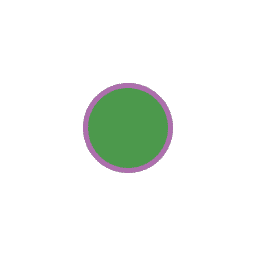

In [29]:
gdg.to_pil(target)